# <center>Trabajo Práctico Computacional 1:<br>Conceptos Básicos</center>

Grupo 9: Facundo Joaquı́n Garcı́a, Agustı́n Brusco, Eitan Sprejer

# Punto 2: Redes Social de Delfines

In [1]:
# Imports
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

try:
    from pandarallel import pandarallel
    pandarallel.initialize(progress_bar=True)
except ModuleNotFoundError:
    if input('Install pandarallel? [y/n]') == 'y':
        !pip install pandarallel
        from pandarallel import pandarallel
        pandarallel.initialize(progress_bar=True)

# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 20, "node_color": "#ff0000", "edgecolors": "#911a07",
                "width": 0.4, "edge_color": "black"}
# Para la lectura de los datos:
try:  # En caso de ejecutar el notebook localmente
    dolphins = nx.read_gml("datasets/dolphins.txt")
    genders = pd.read_csv("datasets/dolphinsGender.txt",
                          delimiter = "\t", header = None, names = ["ID", "Gender"])
except FileNotFoundError:    # En caso de ejecutar el notebook en colab
    try:
        os.chdir('/content/CoNet/TP1')
        dolphins = nx.read_gml("datasets/dolphins.txt")
        genders = pd.read_csv("datasets/dolphinsGender.txt",
                              delimiter = "\t", header = None, names = ["ID", "Gender"])
    except FileNotFoundError:
        !git clone https://github.com/facundojgarcia02/CoNet.git
        os.chdir('/content/CoNet/TP1')
        dolphins = nx.read_gml("datasets/dolphins.txt")
        genders = pd.read_csv("datasets/dolphinsGender.txt",
                            delimiter = "\t", header = None, names = ["ID", "Gender"])

genders.set_index("ID", inplace = True)
genders = pd.Series(genders["Gender"])

# Agregamos el atributo de sexo a cada nodo
for i in dolphins.nodes:
    dolphins.nodes[i]["Gender"] = genders[i]
# Por lo que ahora podemos acceder al genero de cada delfin como dolphins.nodes[ID]["Gender"]

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## a) Visualización de la red

In [16]:
def layouts(graph):
    return {
     "Spring": nx.layout.spring_layout(graph, seed=42),
     "Kamada Kawai": nx.layout.kamada_kawai_layout(graph),
     "Random": nx.layout.random_layout(graph, seed=42),
     "Shell": nx.layout.shell_layout(graph),
     "Spectral": nx.layout.spectral_layout(graph),
     "Spiral": nx.layout.spiral_layout(graph)
    }


edge_homophility = [genders.loc[i[0]] == genders.loc[i[1]] for i in dolphins.edges]

for k, l in layouts(dolphins).items():
    fig, ax = plt.subplots(1, 1, figsize = (14, 6))
    nx.draw(
            dolphins, 
            with_labels=False, 
            node_size=100, 
            edgecolors="white",
            width=0.4, 
            node_color=["red" if dolphins.nodes[node]["Gender"] == "f" 
                          else ("blue" if dolphins.nodes[node]["Gender"] == "m" else "gray") 
                          for node in dolphins.nodes],

            edge_color=["red" if (h and  genders.loc[i[0]] == "f")
            else "blue" if (h and  genders.loc[i[0]] == "m")
            else "green" if (genders.loc[i[0]] == "f" and genders.loc[i[1]] == "m") or (genders.loc[i[0]] == "m" and genders.loc[i[1]] == "f")
            else "gray"
            for i, h in zip(dolphins.edges, edge_homophility)],
            pos=l)
    ax.set_title(k)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Los mejores layouts para este grafo resultaron ser spring y kamada kawai, ya que se logran distinguir los clusters homofílicos con mayor facilidad.

## b) Estudio de la homofilia respecto del género

### i) Calculo de homofilia y comparación con distribuciones aleatorias

In [17]:
# Definición de funciones auxiliares:
def get_homophily(series, graph):
    homo_edges = [series.loc[i[0]] == series.loc[i[1]] for i in graph.edges]
    homophily = sum(homo_edges)/len(homo_edges)
    return homophily


def shuffle_series(series: pd.Series, seed: int = 42) -> pd.Series:
    idx = series.index
    series_mod = series.sample(frac=1.0, random_state= seed, )
    series_mod.index = idx
    return series_mod

In [18]:
#Conseguimos la homofilia de la red original.
homophily = get_homophily(genders, dolphins)
print(f"La homofilia de la red contenida en dolphins.txt es aproximadamente {homophily:.3g}")

La homofilia de la red contenida en dolphins.txt es aproximadamente 0.604


**Nota:** Dada la presencia de delfines cuyo sexo no pudo ser determinado (y que no presentan enlaces entre sí), el valor obtenido de homofilia presenta una cota inferior a la homofilia en la red social real de delfines, la cual solo puede ser mayor que la medida de esta manera.

Esto último es debido a que si uno de los delfines de sexo no identificado fuera, por ejemplo, masculino, entonces sus vinculos con otros machos aumentarían la homofilia de la red. Sin embargo, en el análisis actual donde se lo considera un valor distinto, sus enlaces no aumentan la homifilia de la red.

In [21]:
def parallel_homophily(s):
    #Mezclamos los generos y copiamos la red para no transformarla.
    shuffled_genders = shuffle_series(genders, seed=s)
    dolphins_copy = dolphins.copy()

    #Cambiamos los generos de la copia de dolphins con los mezclados.
    for i in dolphins_copy.nodes: 
        dolphins_copy.nodes[i]["Gender"] = shuffled_genders[i]
    return get_homophily(shuffled_genders, dolphins_copy)


num_muestras = 1000000
try:
    h = np.load(f"{num_muestras} iters.npy")  # Intenta cargar los valores precalculados
    print(f'Se cargaron exitosamente {num_muestras} valores precalculados.')
except FileNotFoundError:
    df_parallel = pd.DataFrame({"seed":[i for i in range(num_muestras)]})
    df_parallel["homophily"] = df_parallel["seed"].parallel_apply(parallel_homophily)
    h = df_parallel["homophily"].to_numpy()
    np.save(f"{num_muestras} iters.npy", h)

Se cargaron exitosamente 1000000 valores precalculados.


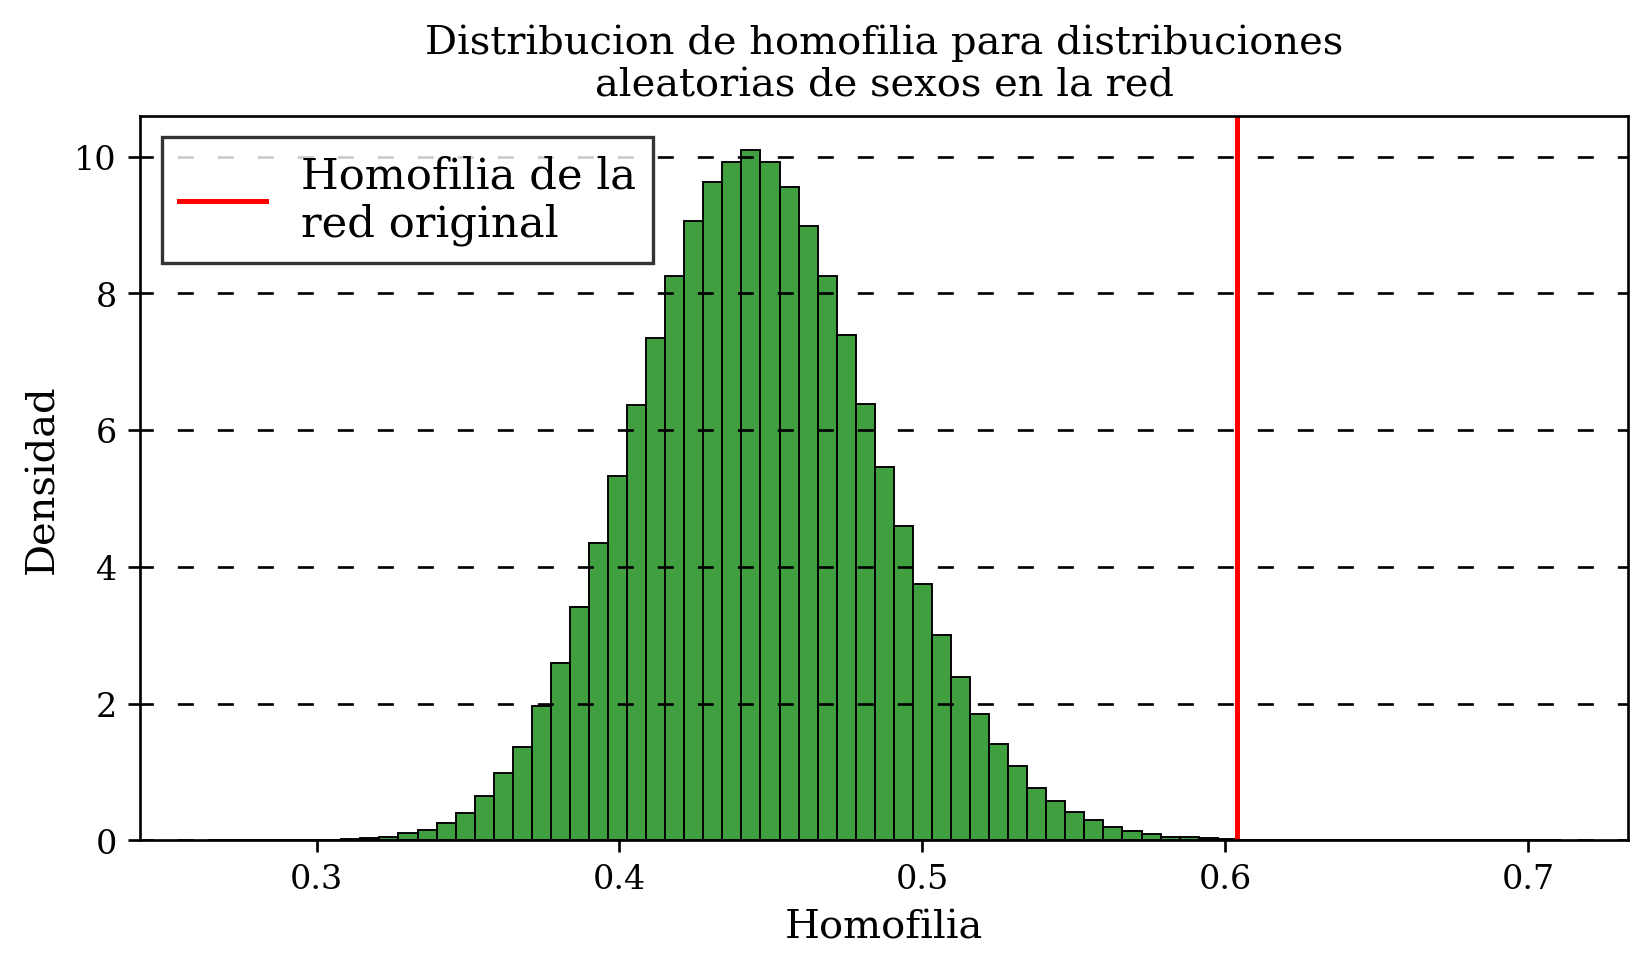

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig.set_facecolor("white")
sns.histplot(h, color="green", stat="density", bins = 71)
plt.title("Distribucion de homofilia para distribuciones\naleatorias de sexos en la red")
plt.ylabel("Densidad")
plt.xlabel("Homofilia")
plt.grid(axis="y", linestyle=(1, (6, 9)), color="black")
plt.axvline(homophily, color="red", label="Homofilia de la\nred original")
plt.legend(fancybox=False, edgecolor="black", fontsize=13)
plt.show()

### ii) Cálculo de los valores medios esperados para la distribución nula

In [23]:
print(f"Dada la distribución nula, se esperaría que la homofilia se encuentre en el intervalo ({h.mean():.3f} ± {h.std(ddof=1):.3f})")

Dada la distribución nula, se esperaría que la homofilia se encuentre en el intervalo (0.443 ± 0.040)


Ahora, estimamos el valor medio con dos métodos distintos:

Un primer método, bastante ineficiente, consiste en tomar pares de delfines de forma aleatoria y obtener el cociente de pares del mismo sexo y la cantidad de pares formados. **Cuidado si deciden correr esta celda, toma bastante tiempo para el N=1.000.000 seteado actualmente.**

In [24]:
N = 1_000_000
coincide = 0
for i in range(N):
    random_sample = genders.sample(2)
    if random_sample.iloc[0] == random_sample.iloc[1]:
        coincide += 1
print(f"Valor medio estimado numéricamente: {coincide/N:.3g}")

Valor medio estimado numéricamente: 0.443


Un segundo método, mucho más exacto y eficiente, consiste en evaluar una expresión analítica para el cociente de posibles enlaces homofilos sobre el total de enlaces posibles en la red. Dados $N$ nodos que representan delfines de los cuales $M$ son másculinos y $F$ son femeninos, se tienen $\binom{N}{2}$ posibles enlaces, de los cuales $\binom{M}{2}+\binom{F}{2}$ representan enlaces homofilos. Así, usando que $\binom{n}{2} = \frac{n (n-1)}{2}$ se puede calcular la homofilia esperada para la red según:

$$h = \frac{M (M-1) + F (F - 1)}{N (N-1)}$$


In [25]:
N = genders.size
male, female = genders.value_counts().to_numpy()
h_expected = (male*(male-1) + female*(female-1))/(N*(N-1))
print(f"Valor medio estimado analíticamente: {h_expected:.3g}")

Valor medio estimado analíticamente: 0.443


### iii) Estimación de la significancia estadística

In [26]:
p_value = len(h[h > homophily])/num_muestras
print(f"El p-valor de la homofilia obtenida es aproximadamente {p_value:.2g}")

El p-valor de la homofilia obtenida es aproximadamente 0.00012
